# Tutorial 1: Differential Spatial Expression (DSE) Analysis in Mouse Brain 

In this tutorial, we will conduct a Differential Spatial Expression (DSE) analysis focusing on a mouse hypothalamic preoptic region dataset. This example will demonstrate how to preprocess the data and identify differentially spatially expressed genes across samples.

*Dataset Reference*: Jeffrey R. Moffitt et al., *Molecular, spatial, and functional single-cell profiling of the hypothalamic preoptic region*, *Science*, 362, eaau5324 (2018). DOI: 10.1126/science.aau5324

**Note**: Ensure all necessary libraries are installed, and you have a compatible environment set up before running the code cells.

If you have any questions, please contact Yeojin Kim at ykim3030@gatech.edu.

## Preprocessing

In the preprocessing step, we will prepare our spatial transcriptomics (ST) dataset for analysis. This includes steps like:
- **Data filtering**: Removing cells with low gene counts and genes expressed in fewer than a threshold number of cells.
- **Normalization**: Scaling and log-transforming the expression for downstream analysis.

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [22]:
import numpy as np
import matplotlib.pyplot as plt 
import scanpy as sc
import pandas as pd
import igraph
import pickle

In [23]:
import SpaceExpress as se

The original data can be downloaded from [here](https://datadryad.org/stash/dataset/doi:10.5061/dryad.8t8s248). Check the `Tutorial_data.ipynb` for generating anndata h5ad file from the original dataset. We selected sections of naïve mice (ID 5) and pup-exposed mice (ID 36) at bregma 0.16 mm for the analysis. Each sample contains 5,839 and 5,835 cells, respectively. The expression values for each section are stored in an AnnData h5ad format, along with the associated metadata for each sample. The location of each cell is stored in the obsm['spatial'] column.

In [24]:
# Load the data 
file_list = ['5', '36'] # 5: Naive, 36: Pup-exposed
adata_list = [sc.read_h5ad(f'./Tutorial_data/MERFISH-mouse-{f}.h5ad') for f in file_list]

In [25]:
# Normalization
for i, adata in enumerate(adata_list):
    genes_to_keep = [gene for gene in adata.var_names if 'Blank' not in gene]
    adata = adata[:, genes_to_keep].copy() 
    sc.pp.filter_genes(adata, min_cells=3)
    sc.pp.filter_cells(adata, min_genes=3)
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    adata_list[i] = adata

g = set.intersection(*(set(adata.var_names) for adata in adata_list))
adata_list = [adata[:, list(g)] for adata in adata_list]

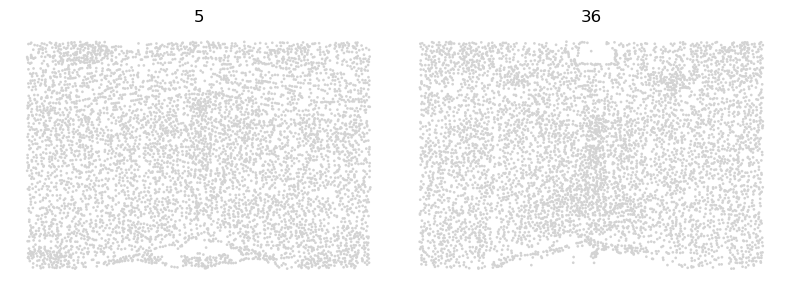

In [26]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(8, 3))  # Adjust the figure size as needed

for i in range(len(adata_list)):
    adata = adata_list[i]
    ax = axes[i]
    plt.rcParams["font.size"] = 10
    sc.pl.embedding(adata, basis="spatial", s=15, show=False, ax=ax)
    ax.set_title(file_list[i])
    ax.axis('off')

plt.tight_layout()
plt.show()

## 1) Constructing the k-Nearest Neighbor Graph

In this step, we'll build a k-nearest neighbor (k-NN) graph to capture local spatial relationships among cells. This graph forms a critical component of the spatial embedding in SpaceExpress, as it defines neighboring relationships that are used for downstream spatial analysis.

- **Choosing k**: The `choose_k` function helps to select an optimal number of neighbors for the k-NN graph. While you can set this value manually, we recommend using `choose_k` for data-driven selection. The function will identify the smallest k that results in the fewest disconnected components in the graph. If k < 20 does not yield a fully connected graph, the function will recommend the smallest k that minimizes disconnected components. 

In [27]:
# Step 1: Automatically select the optimal k for the entire dataset
k = se.choose_k(adata_list)

Construct the k-nearest neighborhood graph using k = 4...
Construct the k-nearest neighborhood graph using k = 4...
Choose k = 4 for all datasets...


Once k is chosen, we proceed to build the k-NN graph for each dataset in the analysis.

- **shortest_path**: The `shortest_path` function generates a shortest path distance matrix from the k-NN graph, capturing spatial distances between neighboring cells. If the k-NN graph of a sample contains disconnected components, this function adds the minimum number of edges required to ensure a fully connected graph by linking isolated clusters or nodes to their nearest neighbors. This step is essential for accurately calculating spatial relationships between cells.

In [28]:
!mkdir -p ./Tutorial_data/Tutorial_1_data

In [29]:
# Step 2: Construct and save the k-nearest neighbor graph for each dataset
for i in range(len(adata_list)):
    adata = adata_list[i]
    se.shortest_path(adata.obsm['spatial'], f'Tutorial_data/Tutorial_1_data/MERFISH-mouse-{file_list[i]}-shortest-paths.pkl', k = k)

Shortest paths already exist at Tutorial_data/Tutorial_1_data/MERFISH-mouse-5-shortest-paths.pkl...
Shortest paths already exist at Tutorial_data/Tutorial_1_data/MERFISH-mouse-36-shortest-paths.pkl...


## 2) Round 1 of DSE Gene Detection

In this section, we initiate the first round of Differential Spatial Expression (DSE) gene detection.

In [31]:
# Step 1: Define the list of shortest path files for each sample
shortest_file_path_list = [f'Tutorial_data/Tutorial_1_data/MERFISH-mouse-{i}-shortest-paths.pkl' for i in file_list]

# Step 2: Train the SpaceExpress model
embedding_before_filtered = se.train_SpaceExpress_multi(
    adata_list, 
    shortest_file_path_list, 
    epochs = 100
)

Size of the input data: [(5839, 155), (5835, 155)]
number of genes: 155
Start training...


Epoch 100/100: 100%|██████████| 100/100 [04:17<00:00,  2.58s/it, loss=71310.5078]


In [32]:
import threading

# Check the current number of threads used for multi-threading
print(f"Number of threads: {threading.active_count()}")

Number of threads: 11


The `SpaceExpress_DSE` function supports multi-threading to speed up computation. For these two mouse brain datasets, which contain approximately 12,000 cells in total, using k=300 typically takes around 5 minutes on 10 threads. If your system has limited CPU resources, you can reduce the number of threads (`n_jobs`) or decrease the value of k (though it is recommended not to go below 100) to optimize resource usage and avoid overloading.

In [33]:
# Step 3: Identify DSE genes
fdr_before_filtered, _ = se.SpaceExpress_DSE(embedding_before_filtered, adata_list, k=300)
summary_before_filtered = se.summary_DSE(fdr_before_filtered, threshold=0.001)
dse_genes_before_filtered = list(set([item for sublist in summary_before_filtered['DSE'].tolist() for item in sublist]))
non_dse_genes_before_filtered = [i for i in adata_list[0].var_names.tolist() if i not in dse_genes_before_filtered]

Processing:   0%|          | 0/620 [00:00<?, ?it/s]

Processing: 100%|██████████| 620/620 [38:16<00:00,  3.70s/it]


## 3) Round 2 of DSE genes detection

This round is recommended. It first removes the previously detected DSE genes and then retrains the SpaceExpress model. Removing strong DSE genes helps in creating a more stable coordinate system for spatial analysis.

In [34]:
# Filter out the detected DSE genes from the dataset for retraining
adata_list_filtered = [adata[:, non_dse_genes_before_filtered] for adata in adata_list]
print('number of filtered genes: ',len(dse_genes_before_filtered))

number of filtered genes:  37


In [35]:
# Train the SpaceExpress model with the filtered dataset
se_embedding = se.train_SpaceExpress_multi(
    adata_list_filtered, 
    shortest_file_path_list,
    epochs = 100
)
# Assign the embeddings to each sample in adata_list
for i in range(len(adata_list)):
    adata_list[i].obsm['SpaceExpress'] = se_embedding[i]

Size of the input data: [(5839, 118), (5835, 118)]
number of genes: 118
Start training...


Epoch 100/100: 100%|██████████| 100/100 [04:56<00:00,  2.97s/it, loss=76884.2656]


In [36]:
# Perform DSE detection on the updated embeddings
df_fdr, adata_fdr = se.SpaceExpress_DSE(se_embedding, adata_list, k = 300)

Processing: 100%|██████████| 620/620 [33:21<00:00,  3.23s/it]


In [37]:
# (Optional) Save the embedding and analysis results
# Uncomment to save: 
# pickle.dump([se_embedding, adata_list, df_fdr, adata_fdr], open("Tutorial_data/Tutorial_1_data/result.pkl", "wb"))
# [se_embedding, adata_list, df_fdr, adata_fdr] = pickle.load(open("Tutorial_data/Tutorial_1_data/result.pkl", "rb"))

In [38]:
# Summary of DSE Results
se.summary_DSE(df_fdr)

,Dim,DSE Count,DSE
0,0,8,"[Gal, Mlc1, Sst, Gnrh1, Tac1, Cartpt, Adcyap1,..."
1,1,16,"[Ttyh2, Cspg5, Mlc1, Ndrg1, Sst, Gjc3, Gpr165,..."
2,2,17,"[Gal, Slc17a6, Mlc1, Sst, Ucn3, Th, Gnrh1, Scg..."
3,3,12,"[Gal, Mlc1, Sst, Th, Gnrh1, Oxt, Tac1, Cpne5, ..."


In [39]:
flat_fdr = df_fdr.unstack().reset_index()
flat_fdr.columns = ['Gene', 'Dimension', 'FDR']
top_10_fdr = flat_fdr.sort_values(by='FDR').head(10)
top_10_fdr

,Gene,Dimension,FDR
115,Sst,3,0.0
231,Gnrh1,3,0.0
289,Mbp,1,0.0
114,Sst,2,0.0
467,Oxt,3,0.0
502,Tac1,2,0.0
55,Gal,3,0.0
54,Gal,2,0.0
503,Tac1,3,0.0
522,Cartpt,2,0.0


## Visualization of the DSE Result

- **plot_DSE**: This function visualizes the results of DSE analysis. By specifying the gene name and dimension of interest, `plot_DSE` displays the differential spatial expression patterns across naive and pup-exposed samples. The function also shows spline model fitting to highlight expression pattern differences between the samples.

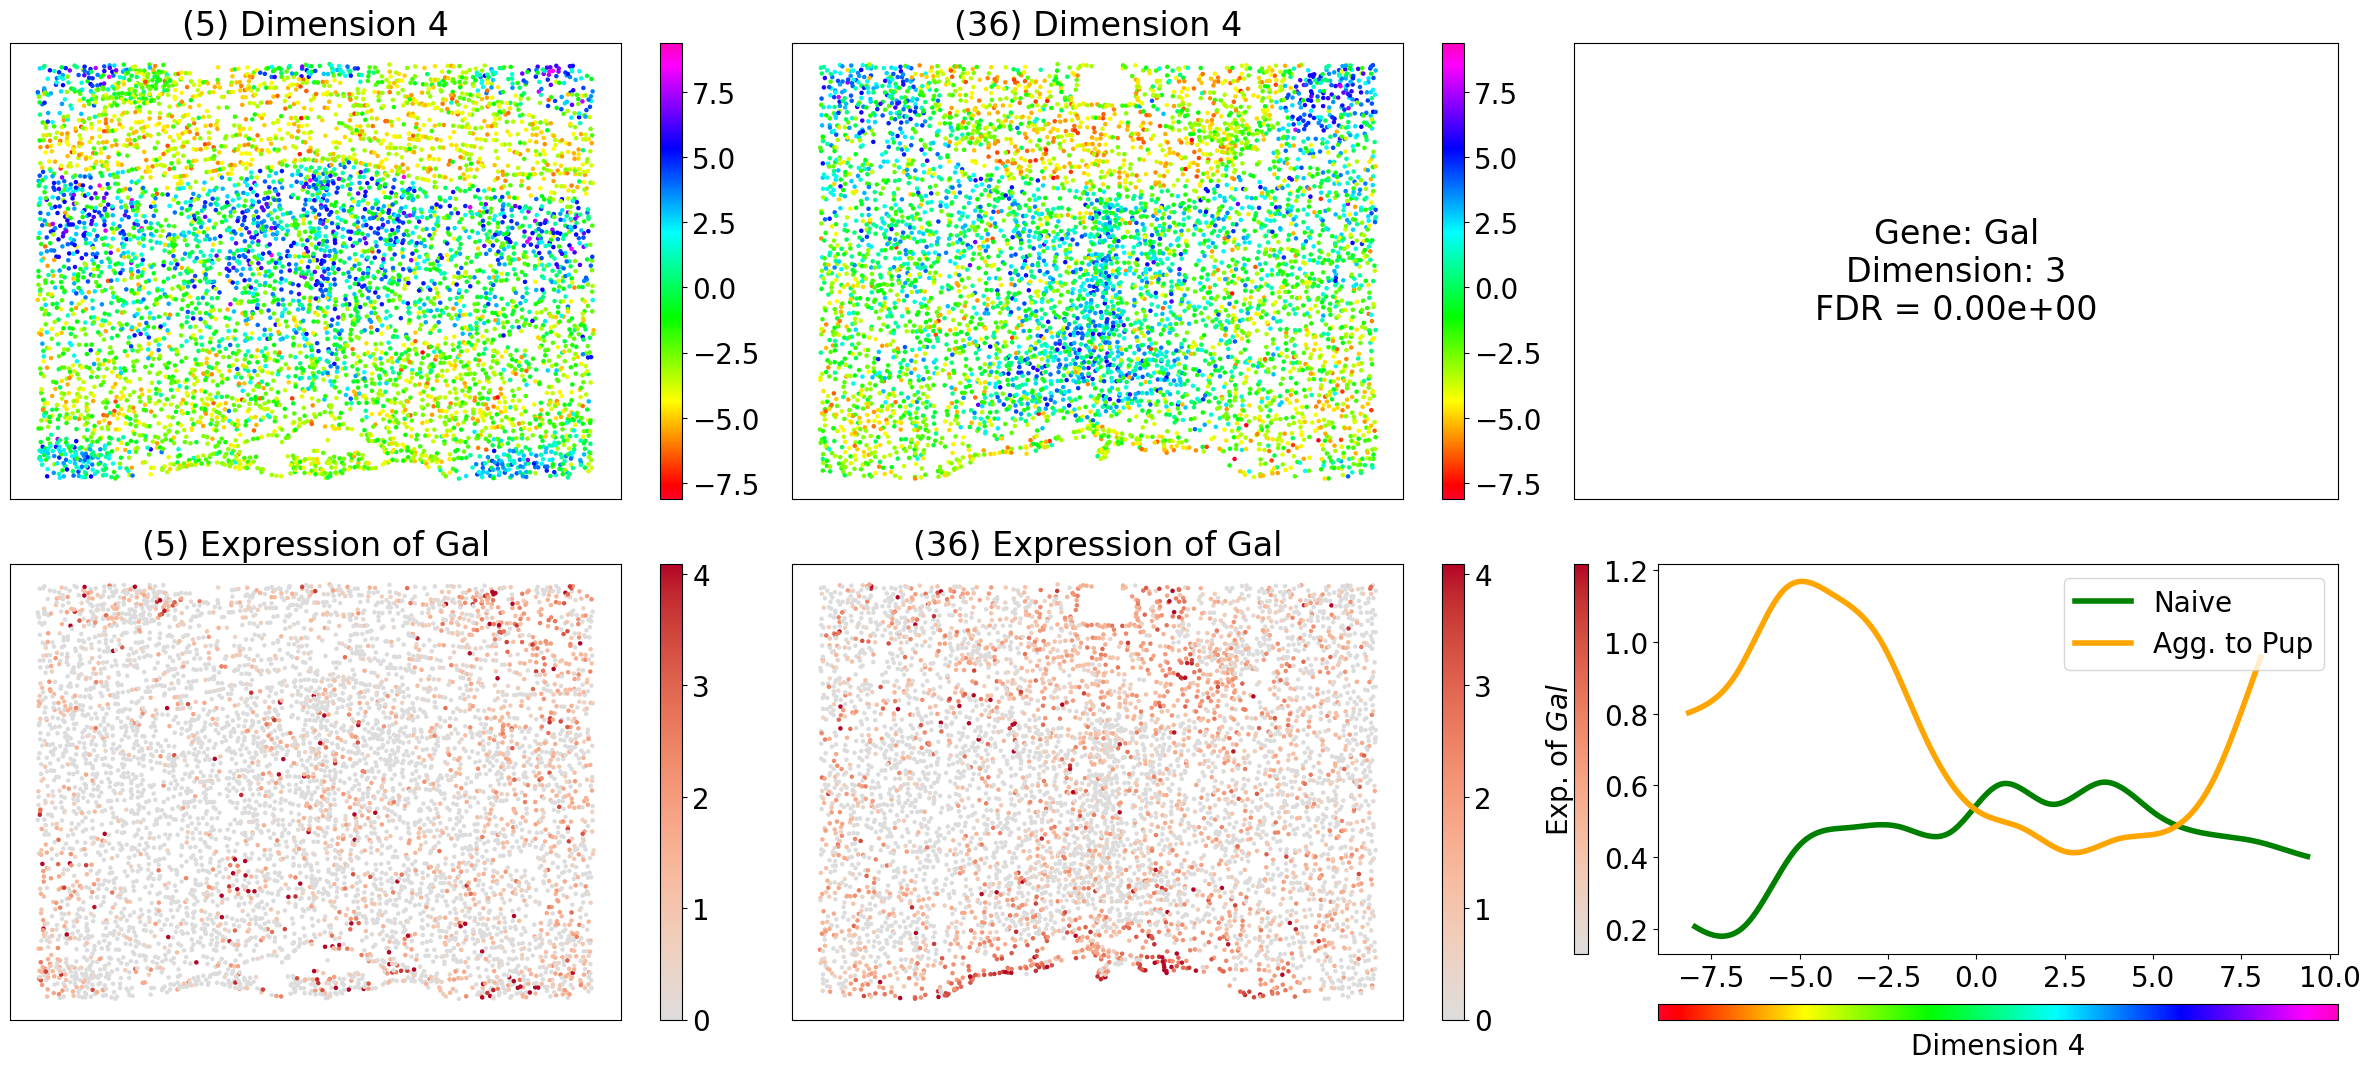

In [40]:
# Example usage of plot_DSE function to visualize DSE results for a specific gene and dimension
fig = se.plot_DSE(adata_fdr, df_fdr, file_list, gene_name = 'Gal', dimension = 3)